In [27]:
# | default_exp tsfeatures.image

In [1]:
import json
import os
import warnings
from datetime import datetime, timedelta

import lightning.pytorch as pl

# | export
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import torch.nn as nn
from plotly.subplots import make_subplots
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset, Subset, random_split

warnings.simplefilter("ignore", category=UserWarning)
from tqdm import tqdm

tqdm.pandas()
torch.set_float32_matmul_precision("medium")

In [2]:
# | export


def transform_to_images(ts_series):
    ts_series = ts_series.dropna().values  # Drop NaNs safely
    ts_series = ts_series.reshape(-1, 1)  # Reshape for pyts compatibility

    # Apply MinMax Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_series = scaler.fit_transform(ts_series).reshape(1, -1)

    # Generate images
    rp = RecurrencePlot().fit_transform(ts_series)[0]  # RP Image
    gaf = GramianAngularField(method="summation").fit_transform(ts_series)[0]  # GAF Image
    mtf = MarkovTransitionField().fit_transform(ts_series)[0]  # MTF Image

    return torch.stack(
        [
            torch.tensor(rp, dtype=torch.float32),
            torch.tensor(gaf, dtype=torch.float32),
            torch.tensor(mtf, dtype=torch.float32),
        ]
    )

In [3]:
# | export


def plot_ts2img(ts_series):
    timestamps = ts_series.index
    rp_image, gaf_image, mtf_image = transform_to_images(ts_series)

    # Create RGB composite image
    rgb_image = torch.stack([rp_image, gaf_image, mtf_image]).permute(1, 2, 0).numpy()  # (H, W, 3)

    # Normalize RGB image to [0, 1] for visualization
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

    # Create subplots (3 rows, 2 columns)
    fig = make_subplots(
        rows=3,
        cols=2,
        subplot_titles=[
            "Original Time Series",
            "Combined RGB Image",
            "Gramian Angular Field (GAF)",
            "Markov Transition Field (MTF)",
            "Recurrence Plot (RP)",
        ],
    )

    # 🟢 Plot Time Series (Top-Left)
    fig.add_trace(
        go.Scatter(
            x=timestamps,
            y=ts_series,
            mode="lines+markers",
            line=dict(color="blue"),
            name="Time Series",
        ),
        row=1,
        col=1,
    )

    # 🔵 Plot Recurrence Plot (RP) (Top-Right)
    fig.add_trace(
        go.Heatmap(z=rp_image.numpy(), colorscale="gray", name="Recurrence Plot", showscale=False),
        row=3,
        col=1,
    )

    # 🟠 Plot Gramian Angular Field (GAF) (Middle-Left)
    fig.add_trace(
        go.Heatmap(
            z=gaf_image.numpy(), colorscale="gray", name="Gramian Angular Field", showscale=False
        ),
        row=2,
        col=1,
    )

    # 🔴 Plot Markov Transition Field (MTF) (Middle-Right)
    fig.add_trace(
        go.Heatmap(
            z=mtf_image.numpy(), colorscale="gray", name="Markov Transition Field", showscale=False
        ),
        row=2,
        col=2,
    )

    # 🌈 Plot RGB Composite Image (Bottom-Center)
    fig.add_trace(
        go.Heatmap(
            z=rgb_image[:, :, 0],  # Use the red channel as intensity
            colorscale="rainbow",
            name="RGB Composite",
            showscale=False,
        ),
        row=1,
        col=2,
    )

    # Customize layout
    fig.update_layout(
        title_text="Time Series & Image Transformations", height=1000, width=1200, showlegend=False
    )

    fig.show()

In [4]:
from ts.utils import generate_time_series

ModuleNotFoundError: No module named 'ts'

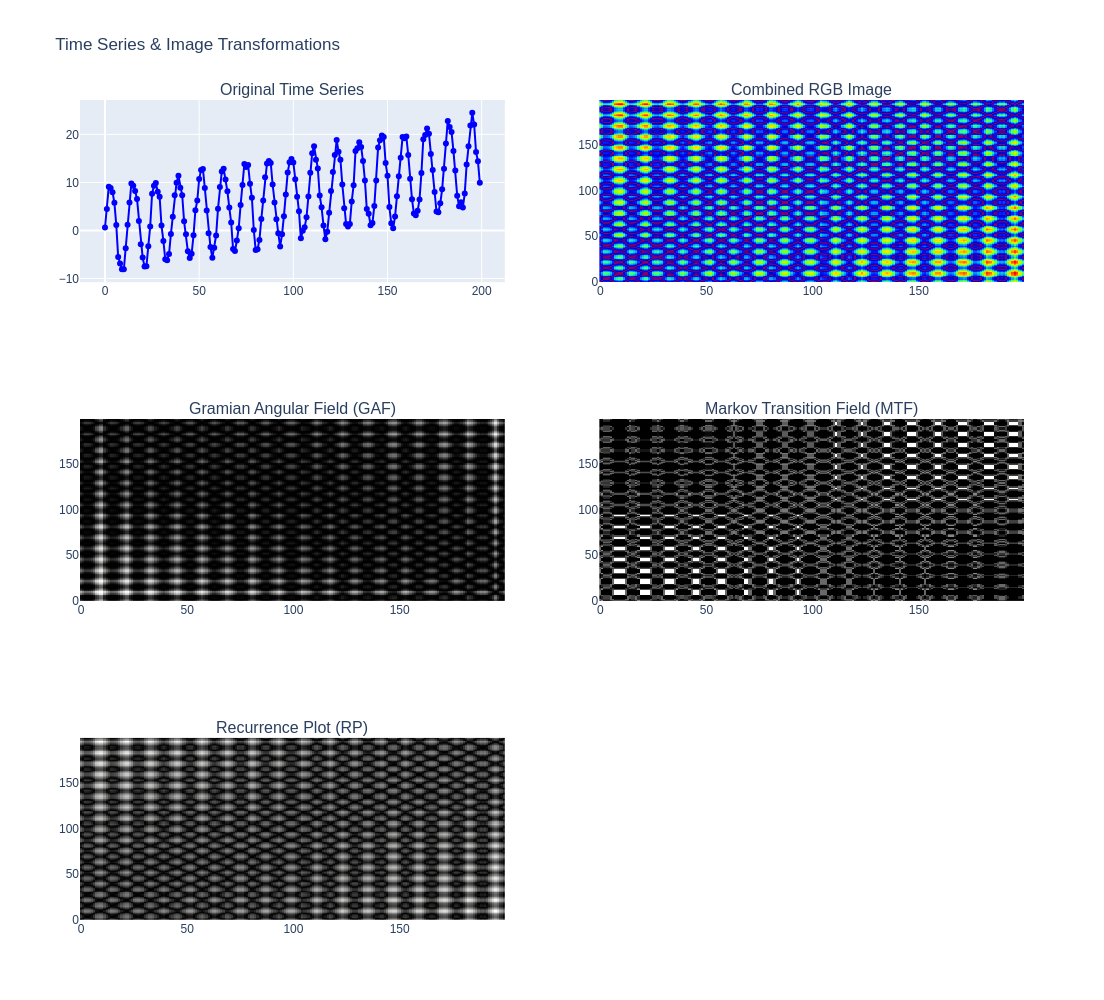

In [58]:
# | hide
ts_series = generate_time_series(
    n_points=200, trend_slope=0.07, seasonality_period=12, seasonality_amplitude=9, noise_std=0.9
)
plot_ts2img(ts_series)

In [ ]:
# Load & preprocess data
df = pd.read_parquet("data/m4_preprocessed.parquet")
df.sort_values("no_of_datapoints", inplace=True)

# Try on smaller dataset
df = df[df.no_of_datapoints <= 468]

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df.best_model.values)
labels = df.label.to_dict()
classes = {idx: class_name for idx, class_name in enumerate(le.classes_)}
with open("classes.json", "w") as f:
    json.dump(classes, f)

df.drop(columns=["best_model", "no_of_datapoints", "label"], inplace=True)
ts_series = df.iloc[20].dropna()

In [3]:
# df[df.index.map(lambda x: x[0]) == "Q"]

In [4]:
# import os
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# from tqdm import tqdm
# import json  # For saving labels in a single JSON file

# # Create directory for storing data
# data_dir = "model_classification"
# os.makedirs(data_dir, exist_ok=True)

# # Dictionary to store labels
# labels_dict = {}

# # Save (image, label) pairs
# for idx in tqdm(range(len(df)), desc="Transforming & Saving (X, y)"):
#     ts = df.iloc[idx]
#     img_tensor = transform_to_images(ts)  # Ensure this returns a torch tensor of shape (3, seq_len, seq_len)

#     # Convert to PIL image
#     to_pil = transforms.ToPILImage()
#     img_pil = to_pil(img_tensor)

#     # Save image
#     img_path = f"{data_dir}/{idx}.png"
#     img_pil.save(img_path)

#     # Store label in dictionary
#     labels_dict[idx] = labels[ts.name]

# # Save all labels in a single JSON file
# labels_path = os.path.join(data_dir, "labels.json")
# with open(labels_path, "w") as f:
#     json.dump(labels_dict, f)

In [5]:
# # Create directory for storing data
# data_dir = "processed_data"
# os.makedirs(data_dir, exist_ok=True)

# # Save (image, label) pairs
# for idx in tqdm(range(len(df)), desc="Transforming & Saving (X, y)"):
#     ts = df.iloc[idx]
#     img_tensor = transform_to_images(ts)  # Ensure this returns a torch tensor
#     sample = {"image": img_tensor, "label": torch.tensor(labels[ts.name], dtype=torch.long)}
#     torch.save(sample, f"{data_dir}/{idx}.pt")  # Save both X and y together

In [6]:
import os

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class TimeSeriesDataset(Dataset):
    """Loads time series image data from .png files and corresponding labels from labels.json."""

    def __init__(self, data_dir, resize_shape=(350, 350), transform=None):
        self.data_dir = data_dir
        self.image_files = sorted(
            [f for f in os.listdir(data_dir) if f.endswith(".png")],
            key=lambda x: int(x.split(".")[0]),
        )  # Ensure correct order

        self.labels = self.load_labels()  # Load labels from labels.json
        self.resize_shape = resize_shape
        self.transform = transform if transform else self.default_transform()

    def load_labels(self):
        """Loads labels from a single JSON file."""
        import json

        labels_path = os.path.join(self.data_dir, "labels.json")
        with open(labels_path, "r") as f:
            return json.load(f)

    def default_transform(self):
        """Returns a default transformation pipeline including resizing."""
        return transforms.Compose(
            [
                transforms.Resize(self.resize_shape),
                transforms.ToTensor(),  # Converts to [0, 1] float tensor
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")  # Convert to 3-channel RGB

        # Apply transformation
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[str(idx)], dtype=torch.long)  # Load label from JSON
        return img, label

In [7]:
import torch
import torch.nn.functional as F


def collate_interplot2max_fn(batch):
    """
    Custom collate function to handle variable-length tensors.
    Uses interpolation instead of padding to resize all tensors to the max (seq_len, seq_len).
    """
    images, labels = zip(*batch)  # Unpack batch

    # Find the max (seq_len, seq_len) across the batch
    max_size = max(img.shape[1] for img in images)  # Assuming (3, seq_len, seq_len)

    # Interpolate all tensors to (3, max_size, max_size)
    images = torch.stack(
        [
            F.interpolate(
                img.unsqueeze(0), size=(max_size, max_size), mode="bilinear", align_corners=False
            ).squeeze(0)
            for img in images
        ]
    )

    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    return images, labels


def collate_truncate2min_fn(batch):
    """
    Custom collate function to handle variable-length tensors.
    Truncates all tensors to the minimum (seq_len, seq_len) size in the batch.
    """
    images, labels = zip(*batch)  # Unpack batch

    # Find the minimum (seq_len, seq_len) across the batch
    min_size = min(img.shape[-1] for img in images)  # Assuming (3, seq_len, seq_len)
    # Truncate all tensors to (3, min_size, min_size)
    images = torch.stack(
        [img[:, :min_size, :min_size] for img in images]  # Truncate both spatial dimensions
    )

    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    return images, labels


import torch
from PIL import Image
from torchvision import transforms


def collate_fn(batch):
    transform = transforms.Compose(
        [
            transforms.Lambda(
                lambda img: (
                    Image.fromarray(img.numpy().astype("uint8"))
                    if isinstance(img, torch.Tensor)
                    else img
                )
            ),
            transforms.Resize((500, 500)),  # Resize to (500, 500)
            transforms.ToTensor(),  # Convert back to tensor
        ]
    )

    images, labels = zip(*batch)  # Unzip batch into images and labels
    images = [transform(img) for img in images]  # Apply transformations
    images = torch.stack(images)  # Stack images into a batch tensor
    labels = torch.tensor(labels)  # Convert labels to tensor

    return images, labels

In [8]:
class TimeSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir="processed_data",
        batch_size=64,
        num_workers=4,
        val_split=0.1,
        test_split=0.1,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        self.test_split = test_split

    # def setup(self, stage=None):
    #     """Split dataset into train, validation, and test sets based on index."""
    #     full_dataset = TimeSeriesDataset(self.data_dir)
    #     total_size = len(full_dataset)

    #     val_size = int(self.val_split * total_size)
    #     test_size = int(self.test_split * total_size)
    #     train_size = total_size - val_size - test_size

    #     # **✅ Index-based split instead of random_split**
    #     train_idx = list(range(0, train_size))
    #     val_idx = list(range(train_size, train_size + val_size))
    #     test_idx = list(range(train_size + val_size, total_size))

    #     self.train_dataset = Subset(full_dataset, train_idx)
    #     self.val_dataset = Subset(full_dataset, val_idx)
    #     self.test_dataset = Subset(full_dataset, test_idx)

    def setup(self, stage=None):
        """Randomly split dataset into train, validation, and test sets."""
        full_dataset = TimeSeriesDataset(self.data_dir)
        total_size = len(full_dataset)

        val_size = int(self.val_split * total_size)
        test_size = int(self.test_split * total_size)
        train_size = total_size - val_size - test_size

        # ✅ Randomly split dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42),  # Ensure reproducibility
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,  # collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,  # collate_fn=collate_fn
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,  # collate_fn=collate_fn
        )

In [9]:
# %%time
# ds = TimeSeriesDataModule(data_dir="processed_data", batch_size=1,num_workers=0)
# ds.setup(stage='train')
# # Test train loader
# train_loader = ds.train_dataloader()
# for batch_X, batch_y in train_loader:
#     print(batch_X)
#     print("Train Batch Shape:", batch_X.shape, batch_y.shape)  # Check batch shape
#     break

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from torchvision import models


class TSImageClassifier(pl.LightningModule):
    def __init__(
        self,
        model_name="convnext_tiny",
        num_classes=10,
        hidden_feature=512,
        lr=1e-3,
        freeze_backbone=True,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Load model
        self.pretrained_model = self._load_model(model_name)

        # Freeze backbone if required
        # if freeze_backbone:
        #     for param in self.pretrained_model.parameters():
        #         param.requires_grad = False

        # Modify classifier for custom classes
        self._modify_classifier(hidden_feature, num_classes)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

        # Metrics (computed per batch)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.f1_score = torchmetrics.F1Score(
            task="multiclass", num_classes=num_classes, average="macro"
        )
        self.auc = torchmetrics.AUROC(task="multiclass", num_classes=num_classes)

    def _load_model(self, model_name):
        """Load a pretrained model dynamically."""
        model_dict = {
            "convnext_tiny": models.convnext_tiny(weights="IMAGENET1K_V1"),
            "efficientnet_b0": models.efficientnet_b0(weights="IMAGENET1K_V1"),
            "swin_v2_s": models.swin_v2_s(weights="IMAGENET1K_V1"),
            "resnet50": models.resnet50(weights="IMAGENET1K_V1"),
        }
        if model_name not in model_dict:
            raise ValueError(
                f"Model '{model_name}' is not supported. Choose from {list(model_dict.keys())}."
            )
        return model_dict[model_name]

    def _modify_classifier(self, hidden_feature, num_classes):
        """Modify classifier head for different models."""
        if hasattr(self.pretrained_model, "classifier"):
            in_features = self.pretrained_model.classifier[-1].in_features
            self.pretrained_model.classifier[-1] = nn.Sequential(
                nn.Linear(in_features, hidden_feature),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                # nn.Linear(hidden_feature, hidden_feature),
                # nn.ReLU(),
                # nn.Dropout(p=0.3),
                nn.Linear(hidden_feature, num_classes),
            )
        elif hasattr(self.pretrained_model, "fc"):
            in_features = self.pretrained_model.fc.in_features
            self.pretrained_model.fc = nn.Sequential(
                nn.Linear(in_features, hidden_feature),
                nn.ReLU(),
                nn.Dropout(p=0.3),
                # nn.Linear(hidden_feature, hidden_feature),
                # nn.ReLU(),
                # nn.Dropout(p=0.3),
                nn.Linear(hidden_feature, num_classes),
            )

    def forward(self, x):
        return self.pretrained_model(x)

    def compute_metrics(self, logits, y, prefix):
        """Compute Accuracy, F1 Score, and AUC for a given batch."""
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        f1 = self.f1_score(preds, y)
        auc = self.auc(logits, y)

        self.log_dict(
            {
                f"{prefix}_accuracy": acc,
                f"{prefix}_f1": f1,
                f"{prefix}_auc": auc,
            },
            prog_bar=True,
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Log metrics
        self.log("train_loss", loss, prog_bar=True)
        self.compute_metrics(logits, y, "train")

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.compute_metrics(logits, y, "val")

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Log metrics
        self.log("test_loss", loss, prog_bar=True)
        self.compute_metrics(logits, y, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

In [18]:
import json

with open("classes.json", "r") as file:
    classes = json.load(file)

In [19]:
import torch
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms

torch.cuda.empty_cache()

In [20]:
ds = TimeSeriesDataModule(data_dir="model_classification", batch_size=32, num_workers=24)
model = TSImageClassifier(
    model_name="swin_v2_s", num_classes=len(classes), hidden_feature=512, lr=3e-3
)

In [14]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(
    project="ts-classification", name="cnn.model=efficientnet_b0.ds=model_classifier"
)
wandb_logger.experiment.config["model"] = "swin_v2_s"
wandb_logger.experiment.config["ds"] = "model_classifier-full"
wandb_logger.experiment.config["finetune"] = False

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pranav_jha to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
# wandb.finish()

In [25]:
trainer = pl.Trainer(
    # logger=wandb_logger,
    accelerator="auto",
    devices=[0],
    min_epochs=1,
    max_epochs=100,
    enable_checkpointing=True,
    callbacks=[
        pl.callbacks.EarlyStopping("val_loss", patience=5, verbose=False),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
ckpt_path = "model_checkpoints/cnn_model_classification.ckpt"
finetune = False
if finetune:
    trainer.fit(model, ds, ckpt_path=ckpt_path)
else:
    trainer.fit(model, ds)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | pretrained_model | SwinTransformer    | 49.7 M | train
1 | criterion        | CrossEntropyLoss   | 0      | train
2 | accuracy         | MulticlassAccuracy | 0      | train
3 | f1_score         | MulticlassF1Score  | 0      | train
4 | auc              | MulticlassAUROC    | 0      | train
----------------------------------------------------------------
49.7 M    Trainable params
0         Non-trainable params
49.7 M    Total params
198.950   Total estimated model params size (MB)
436       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

RuntimeError: Detected more unique values in `preds` than expected. Expected only 7 but found 9 in `preds`. Found values: tensor([409, 446, 470, 530, 556, 591, 688, 782, 854], device='cuda:0').

In [ ]:
trainer.save_checkpoint("model_checkpoints/cnn_model_classification.ckpt")

In [ ]:
trainer.test(model, ds);

In [ ]:
trainer.validate(model, ds);